In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# df = pd.read_csv('simresults_int_10000.csv')
df = pd.read_csv('simresults_clover_10000.csv')

# observed_values = {
#     'yel': 34,
#     'grn': 68,
#     'blu': 39,
#     'cnt': 94,
#     'blv': 60
# }

observed_values = { # FOR CLOVER ONLY
    'yel': 32,
    'grn': 68,
    'blu': 36,
    'cnt': 91,
    'blv': 52
}


color_map = {
    'cnt': 'm',
    'blu': 'b',
    'blv': 'c',
    'grn': 'g',
    'yel': 'y',
    'red': 'r'
}

name_map = {
    'cnt': 'Contrast + UV',
    'blu': 'Blue',
    'blv': 'Blue + UV',
    'grn': 'Green',
    'yel': 'Yellow'
}

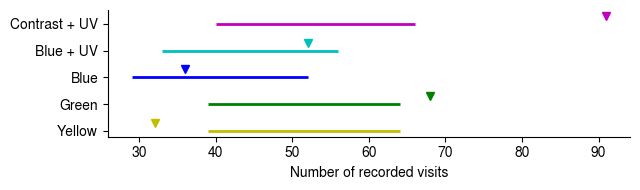

In [ ]:
# new_order = ['cnt', 'blv', 'blu', 'grn', 'yel']
new_order = ['yel', 'grn', 'blu', 'blv', 'cnt']
plt.figure(figsize=(6.5, 2))

for i, col in enumerate(new_order):
    data = df[col].dropna()
    min_val, max_val = data.min(), data.max()
    observed = observed_values[col]
    ci_low, ci_high = np.percentile(data, [2.5, 97.5])
    # plt.hlines(y=i, xmin=min_val, xmax=max_val, color=color_map[col], linewidth=1)
    plt.hlines(y=i, xmin=ci_low, xmax=ci_high, color=color_map[col], linewidth=2)
    plt.plot(observed, i + 0.3, marker='v', color=color_map[col], markersize=6)

plt.yticks(ticks=range(len(new_order)), labels=new_order)
mapped_labels = [name_map.get(col, col) for col in new_order]
plt.yticks(ticks=range(len(new_order)), labels=mapped_labels)
plt.xlabel('Number of recorded visits')
# plt.ylabel('Lure color')
plt.tight_layout()
# plt.savefig('figs/simulation_line_interval.png', format='png', dpi=300)
plt.savefig('figs/simulation_line_interval_clover.svg', format='svg')

In [ ]:
p_values = {}

for col in new_order:
    data = df[col].dropna()
    observed = observed_values[col]
    p_val = (np.sum(data >= observed) if observed > np.median(data) 
             else np.sum(data <= observed)) / len(data)
    p_val *= 2 
    p_values[col] = min(p_val, 1.0)

mapped_p_values = {name_map.get(col, col): p for col, p in p_values.items()}

pval_df = pd.DataFrame.from_dict(mapped_p_values, orient='index', columns=['p-value'])
pval_df = pval_df.sort_index()
pval_df

,p-value
Blue,0.4992
Blue + UV,0.2048
Contrast + UV,0.0000
Green,0.0138
Yellow,0.0018


In [19]:
p_values = {}
directions = {}

for col in new_order:
    sim_data = df[col].dropna()
    obs = observed_values[col]
    median = np.median(sim_data)

    if obs > median:
        p = np.sum(sim_data >= obs) / len(sim_data)
    else:
        p = np.sum(sim_data <= obs) / len(sim_data)

    p = min(p * 2, 1.0)
    p_values[col] = p

    directions[col] = "higher" if obs > median else "lower"

results_df = pd.DataFrame({
    'Observed': observed_values,
    'Median of Sim': df.median(),
    'Direction': directions,
    'Two-tailed p-value': p_values
}).loc[new_order]

results_df.index = [name_map.get(c, c) for c in results_df.index]
results_df

,Observed,Median of Sim,Direction,Two-tailed p-value
Yellow,32,51.0,lower,0.0018
Green,68,51.0,higher,0.0138
Blue,36,40.0,lower,0.4992
Blue + UV,52,44.0,higher,0.2048
Contrast + UV,91,53.0,higher,0.0000


In [ ]:
from statsmodels.stats.multitest import multipletests

raw_pvals = [p_values[col] for col in new_order]
bonf_reject, bonf_pvals, _, _ = multipletests(raw_pvals, method='bonferroni')
fdr_reject, fdr_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

adj_results_df = pd.DataFrame({
    'Observed': [observed_values[col] for col in new_order],
    'Median of Sim': [df[col].median() for col in new_order],
    'Direction': [directions[col] for col in new_order],
    'Raw p-value': raw_pvals,
    'Bonferroni adj p': bonf_pvals,
    'Bonferroni reject (α=0.05)': bonf_reject,
    'FDR adj p': fdr_pvals,
    'FDR reject (α=0.05)': fdr_reject
}, index=[name_map.get(col, col) for col in new_order])

adj_results_df

,Observed,Median of Sim,Direction,Raw p-value,Bonferroni adj p,Bonferroni reject (α=0.05),FDR adj p,FDR reject (α=0.05)
Yellow,32,51.0,lower,0.0018,0.009,True,0.0045,True
Green,68,51.0,higher,0.0138,0.069,False,0.0230,True
Blue,36,40.0,lower,0.4992,1.000,False,0.4992,False
Blue + UV,52,44.0,higher,0.2048,1.000,False,0.2560,False
Contrast + UV,91,53.0,higher,0.0000,0.000,True,0.0000,True
